In [1]:
%matplotlib qt
import os
import pickle
from sdypy import EMA
import numpy as np
import matplotlib.pyplot as plt 
from EMA_functions import *
import pandas as pd
import matplotlib.animation as animation
import matplotlib.cm as cm
import matplotlib.colors as col
import ast

c:\Users\thijsmas\AppData\Local\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
df = pd.read_csv('H:/My Drive/PHD/HSC/file_descriptions_wlocs.csv')
file_name_basis = 'Full_web_ecc2_new2_Floc18_v'
v_vec = [5]
file_name_vec = [file_name_basis + str(x) for x in v_vec]
file_name_vec_video = [x + '_S01.cihx' for x in file_name_vec]
df_filtered = df[df['filename'].isin(file_name_vec_video)]
df_filtered

test = '1D'
if test == '1D':
    # added_string = '_1d_and_2d_roi3x3'
    # added_string = '_1d_roi1x1'
    added_string = '_1d_roi3x3'
    # added_string = '_1d_roi5x5'
    # added_string = '_1d_and_2d_5000_points'
elif test == '2D':
    # added_string = '_1d_and_2d_5000_points'
    added_string = '_1d_and_2d_roi7x7'
    # added_string = '_1d_and_2d_roi9x9'

file_name = file_name_vec_video[0]
file_name_EMAs = os.path.splitext(file_name_vec[0])[0] + added_string
root = 'C:/Users/thijsmas/Documents/GitHub/pyidi_data/EMA structure'
prey_ij = ast.literal_eval(df_filtered['prey_ij'].item())
df_filtered

filename  \
123  Full_web_ecc2_new2_Floc18_v5_S01.cihx   

                                                  path  ecc  loc  mass  \
123  H:\My Drive\PHD\HSC\ecc2\web1\Full_web_ecc2_ne...    2   18  True   

    taut/loose impact/pluck  version  n_frames     fps  Oversatured pixels  \
123      Loose       Impact        5      8000  8000.0                 727   

     Undersatured pixels     prey_ij   spider_ij  
123                18127  (356, 234)  (553, 229)

In [3]:
with open(os.path.join(root, file_name_EMAs + '.pkl'), 'rb') as f:
    EMA_structure = pkl.load(f)
video = EMA_structure.open_video()
EMA_structure.open_impact_data()

H:/My Drive/PHD/HSC\ecc2\web1\Full_web_ecc2_new2_Floc18_v5_S01\Full_web_ecc2_new2_Floc18_v5_S01.cihx


c:\Users\thijsmas\AppData\Local\anaconda3\Lib\site-packages\pyMRAW.py:103: UserWarning: Clipped footage! (Total frame: 8000, Original total frame: 87371)
  warnings.warn('Clipped footage! (Total frame: {}, Original total frame: {})'.format(cih['Total Frame'], cih['Original Total Frame'] ))


Switch between 1D and 2D here!

In [4]:
if test == '1D':
    EMA_structure.tp = EMA_structure.maxima1d 
    EMA_structure.d  = EMA_structure.displacements1D_1Dpoints
    td = EMA_structure.d +  EMA_structure.maxima1d.reshape(len(EMA_structure.maxima1d),1,2)
elif test == '2D':
    EMA_structure.tp = EMA_structure.maxima2d 
    EMA_structure.d  = EMA_structure.displacements2D_2Dpoints
    td = EMA_structure.d +  EMA_structure.maxima2d.reshape(len(EMA_structure.maxima2d),1,2)

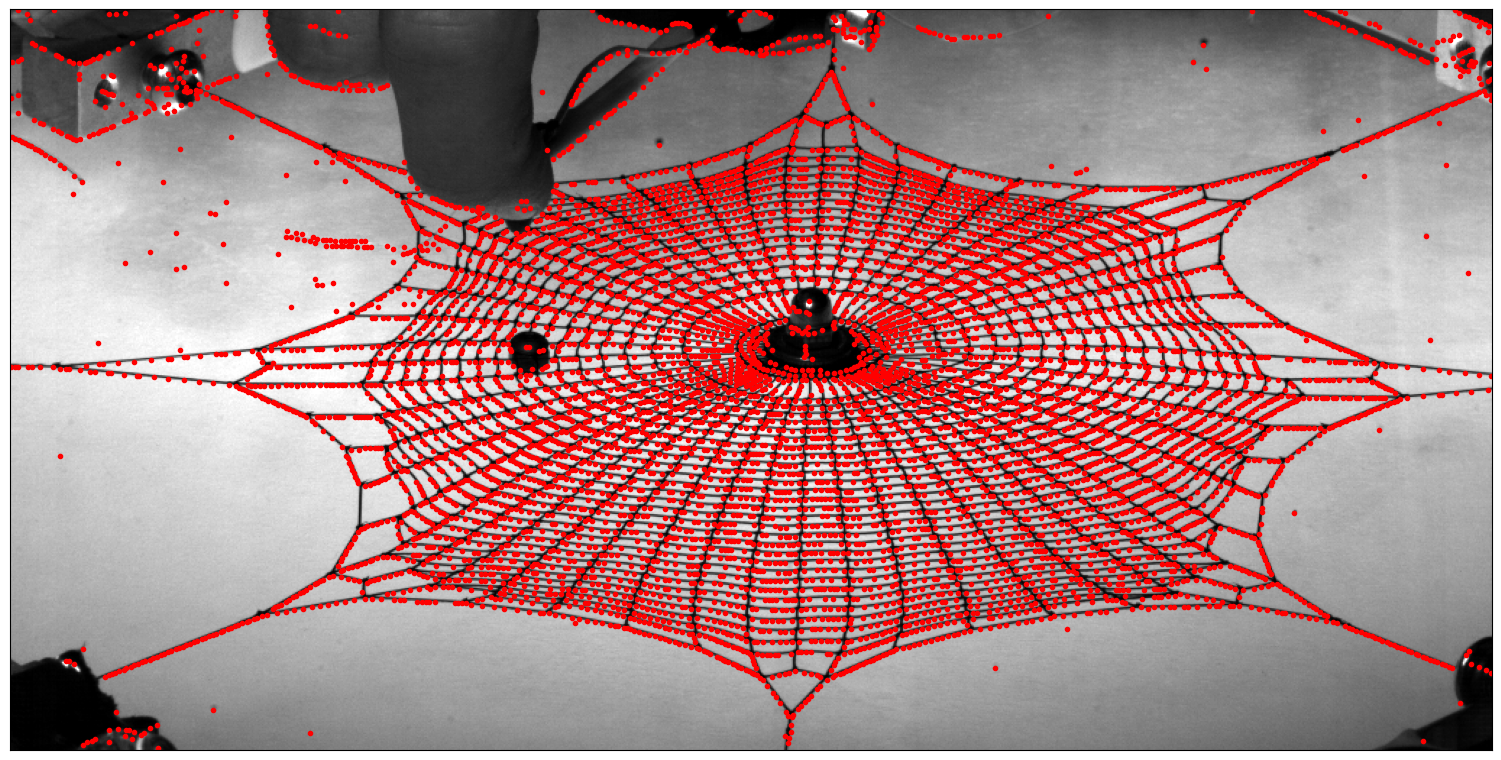

In [5]:
%matplotlib inline
peak_n = 4
sequential_image_n = 0
shift = 0
EMA_structure.nut_idx((prey_ij[0]-shift, prey_ij[1]+shift), exclude_high_amplitude = False, d_lim =25)
fig, ax = EMA_structure.plot_still_frame(video, sequential_image_n, show_saturation = False, tp_nut = False, tp = True, valid_only=False)
fig.savefig(os.path.join(EMA_structure.root_simulations, 'tracking dots', f'Mode_shapes_flat_{EMA_structure.file_name}'+added_string+'.png'), dpi=300, bbox_inches='tight')

In [6]:
%matplotlib qt
ani = EMA_structure.play_video(video, range(1000,video.N-1), interval=30, points=td)

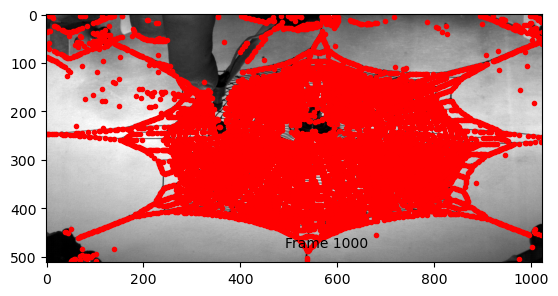

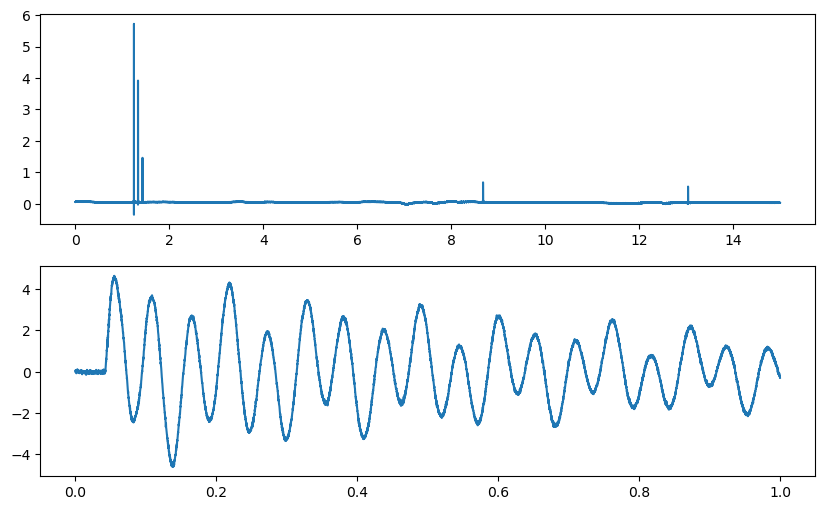

In [7]:
%matplotlib inline
EMA_structure.initialize_signals()
EMA_structure.initialize_displacement(idx='all', dir='y')
EMA_structure.t_camera_raw = EMA_structure.t_camera_raw
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
ax[0].plot(EMA_structure.t_force_raw, EMA_structure.force_raw)
ax[1].plot(EMA_structure.t_camera_raw, EMA_structure.displacements_raw[EMA_structure.nearest_nut_index])

In [8]:
first_zero_id_cam = EMA_structure.find_signal_start(EMA_structure.displacements_raw[EMA_structure.nearest_nut_index], treshold=0.08, approximate_height = 3)
first_zero_id_force = EMA_structure.find_signal_start(EMA_structure.force_raw, peak_n=peak_n, treshold=0.05)
zeros_camera    = EMA_structure.greatest_common_divisor(EMA_structure.fs_camera, EMA_structure.fs_force)
zeros_force     = EMA_structure.n_samples_camera_to_force(zeros_camera)

# Shift and align signals
EMA_structure.t_camera = EMA_structure.shift_time(EMA_structure.t_camera_raw, EMA_structure.t_camera_raw[first_zero_id_cam-zeros_camera])
EMA_structure.t_force = EMA_structure.shift_time(EMA_structure.t_force_raw, EMA_structure.t_force_raw[first_zero_id_force-zeros_force])

# Clip signals
EMA_structure.t_camera          = EMA_structure.clip_signal_before(EMA_structure.t_camera,first_zero_id_cam-zeros_camera)
EMA_structure.displacements     = EMA_structure.clip_signal_before(EMA_structure.displacements_raw, first_zero_id_cam-zeros_camera)
EMA_structure.t_force           = EMA_structure.clip_signal_before(EMA_structure.t_force, first_zero_id_force-zeros_force)
EMA_structure.force             = EMA_structure.clip_signal_before(EMA_structure.force_raw, first_zero_id_force-zeros_force)

last_id_force, last_id_camera   = EMA_structure.find_last_common_time_ids(EMA_structure.t_camera, EMA_structure.t_force)
EMA_structure.t_camera          = EMA_structure.clip_signal_after(EMA_structure.t_camera, last_id_camera)
EMA_structure.displacements     = EMA_structure.clip_signal_after(EMA_structure.displacements, last_id_camera)
EMA_structure.t_force           = EMA_structure.clip_signal_after(EMA_structure.t_force, last_id_force)
EMA_structure.force             = EMA_structure.clip_signal_after(EMA_structure.force, last_id_force)

# Zero Force after impact
EMA_structure.force = EMA_structure.zero_signal_treshold(EMA_structure.force, 0.1)

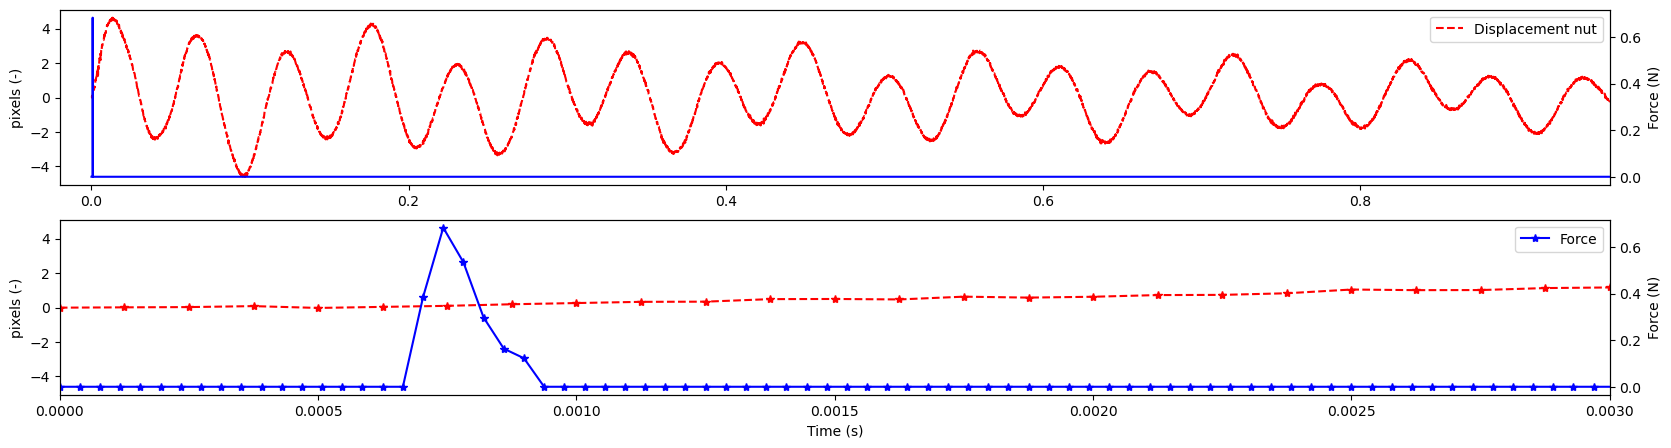

In [9]:
%matplotlib inline
fig, ax = plt.subplots(2,1,figsize=(20,5))
ax0_2 = ax[0].twinx()
ax1_2 = ax[1].twinx()
ax0_2.plot(EMA_structure.t_force, EMA_structure.force,'b-', label='Force (raw))')
ax[0].plot(EMA_structure.t_camera, EMA_structure.displacements[EMA_structure.nearest_nut_index,:],'r--', label=f'Displacement nut')
ax[0].set_xlim([-0.02, EMA_structure.t_camera[-1]])

ax[0].set_ylabel('pixels (-)')
ax0_2.set_ylabel('Force (N)')
ax[0].legend(loc='upper right')


ax1_2.plot(EMA_structure.t_force, EMA_structure.force,'b*-', label='Force')
ax[1].plot(EMA_structure.t_camera, EMA_structure.displacements[EMA_structure.nearest_nut_index,:],'r*--', label=f'Displacement nut')
# ax[1].plot(t_camera2[disp_peaks], disp_nut[disp_peaks], 'rx')
ax[1].set_xlim([0, 0.003])
ax[1].set_ylabel('pixels (-)')
ax1_2.set_ylabel('Force (N)')

# set legend to north east
ax1_2.legend()
ax[1].set_xlabel('Time (s)')
plt.show()
fig.savefig(os.path.join(EMA_structure.root_simulations, 'signals', f'{EMA_structure.file_name} - example impact.png'), dpi=300, bbox_inches='tight')

In [10]:
%matplotlib qt
# Feature filtering parameters for the 2D signals
# d_lim = 10
# z_limit = 0.2
# d_min = 0.9
# f_range = (3, 50)
# H_max_lim = 2e6
# H_peak_min = 2
# smooth_lim = 500
# max_drift = 1.

# Feature filtering parameters for the 1D signals
d_lim = 6
z_limit = 0.25
d_min = 0.5
f_range = (3, 50)
H_max_lim = 1e6
H_peak_min = 2
smooth_lim = 1.
max_drift = 2
max_end_drift = 1.5

EMA_structure.set_freq_properties(padding_ratio=1)
EMA_structure.get_transfer_function()
# EMA_structure.valid_tp(d_lim = 15, z_limit = 0.02, h_type = 'H1')
EMA_structure.valid_tp(d_lim = d_lim, z_limit = z_limit, h_type = 'H1', d_min=d_min, f_range= f_range)

smooth_signals = np.max(np.abs(np.diff(np.linalg.norm(EMA_structure.d, axis=2))), axis = 1) < smooth_lim
# non_drifting = np.abs(np.mean(np.linalg.norm(EMA_structure.d, axis=2), axis=1) < max_drift)
non_drifting = np.abs(np.mean(np.linalg.norm(EMA_structure.d[:,:-100], axis=2), axis=1) < max_drift)
non_drifting2 = np.abs(np.linalg.norm(EMA_structure.d[:,-1], axis=1)) < max_end_drift
H_max = np.max(np.abs(EMA_structure.H1), axis=1)
H_low = H_max<H_max_lim
H_peak_loc = np.argmax(np.abs(EMA_structure.H1), axis=1)
sd_points = H_peak_loc>H_peak_min

EMA_structure.valid_tps = EMA_structure.valid_tps  & smooth_signals & non_drifting & non_drifting2 & sd_points#& H_low
# EMA_structure.valid_tps =  smooth_signals & H_low & non_drifting & EMA_structure.valid_tps & sd_points# & non_drifting & H_low &

print(np.sum(~EMA_structure.exclude_outliers))
print(f'Number of valid points is: {len(EMA_structure.tp[EMA_structure.valid_tps])}/{EMA_structure.tp.shape[0]}')
ani = EMA_structure.play_video(video, range(300,video.N - 1), interval=30, points=td[EMA_structure.valid_tps])

# plt.figure(figsize=(15, 5))
# plt.semilogy(EMA_structure.freq_force, np.abs(EMA_structure.force_fft), label='Force')
# plt.semilogy(EMA_structure.freq_camera, np.abs(EMA_structure.disp_fft[EMA_structure.nearest_nut_index]), label='Displacement')

# plt.semilogy(freq_camera, np.abs(Disp[tp_id])/ np.abs(Force), label='output/input')
# plt.semilogy(freq_camera, np.abs(Disp[nearest_index]), label='Displacement nut')
# plt.plot(EMA_structure.freq_camera[], np.abs(EMA_structure.H1[EMA_structure.valid_tps[0]]), 'r', label='H1')
# for H1_i, peak_loc in zip(EMA_structure.H1[EMA_structure.valid_tps], H_peak_loc[EMA_structure.valid_tps]):
#     plt.semilogy(EMA_structure.freq_force, np.abs(H1_i), 'r', alpha=0.1, linewidth=0.2)
#     plt.semilogy(EMA_structure.freq_force[peak_loc], np.abs(H1_i[peak_loc]), 'ko', alpha=0.3)


# plt.xlim(f_range)
# plt.xlabel('Frequency [Hz]')
# plt.ylabel('Force [N], Displacment [m] amplitude spectra')
# plt.legend()

# coh = np.mean(np.abs(EMA_structure.H1[EMA_structure.valid_tps] / EMA_structure.H2[EMA_structure.valid_tps]), axis=0)
print(np.sum(~smooth_signals), np.sum(~non_drifting), np.sum(~non_drifting2), np.sum(~sd_points), np.sum(~H_low), np.sum(~EMA_structure.valid_tps))

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
for disp_i in EMA_structure.d[EMA_structure.valid_tps, :, 0]:
    ax.plot(EMA_structure.t_camera_raw, disp_i, 'r', alpha=0.2, linewidth=0.2)
# ax.plot(EMA_structure.t_camera, np.mean(EMA_structure.displacements[EMA_structure.valid_tps], axis=0), 'k', label='Mean displacement')

c:\Users\thijsmas\Documents\GitHub\pyidi\scripts\EMA_functions.py:671: RuntimeWarning: invalid value encountered in divide
  self.H2 =  S_xx / S_xf
c:\Users\thijsmas\Documents\GitHub\pyidi\scripts\EMA_functions.py:672: RuntimeWarning: invalid value encountered in divide
  self.Hv =  (S_fx / S_ff * S_xx / S_xf)**0.5


252
Number of valid points is: 5108/8000
2361 1678 1676 2148 1054 2892


In [11]:
# large_x_motion = np.max(EMA_structure.d[EMA_structure.valid_tps, :, 1], axis=1)>.5
# ani = EMA_structure.play_video(video, range(300,video.N - 1), interval=30, points=td[~smooth_signals])

In [12]:
# smooth_signals2 = np.max(np.abs(np.diff(np.linalg.norm(EMA_structure.d, axis=2))), axis = 1) < 15
# fig, ax = plt.subplots(1, 1, figsize=(15, 5))
# for disp_i in EMA_structure.d[~smooth_signals & smooth_signals2, :, 0]:
#     ax.plot(EMA_structure.t_camera_raw, disp_i, 'r', alpha=0.5, linewidth=0.5)
# ax.set_ylim([-7, 7])

In [17]:
cam = EMA.Model(EMA_structure.H1[EMA_structure.valid_tps], EMA_structure.freq_camera, lower=5, upper=300, pol_order_high=230, frf_type = 'receptance')
cam.get_poles(show_progress=True)
# cam.Select_poles.chart_type = 1
cam.select_poles()


100%|█████████████████████████████████████████████████████████████| 230/230 [00:13<00:00, 16.43it/s]


<Figure size 640x480 with 0 Axes>

In [18]:
if test == '1D':
    with open(os.path.join(EMA_structure.root_simulations,'EMA models', f'{EMA_structure.file_name}_1D_roi3x3_5_cam.pkl'), 'wb') as f: #_1D_roi3x3_2_cam
        pkl.dump(cam, f)
elif test == '2D':
    # with open(os.path.join(EMA_structure.root_simulations,'EMA models', f'{EMA_structure.file_name}_2D_roi5x5_2_cam.pkl'), 'wb') as f:
    # with open(os.path.join(EMA_structure.root_simulations,'EMA models', f'{EMA_structure.file_name}_2D_roi7x7_cam.pkl'), 'wb') as f:
    with open(os.path.join(EMA_structure.root_simulations,'EMA models', f'{EMA_structure.file_name}_2D_roi9x9_2_cam.pkl'), 'wb') as f:
        pkl.dump(cam, f)

In [ ]:
# test = '1D'
if test == '1D':
    with open(os.path.join(EMA_structure.root_simulations,'EMA models', f'{EMA_structure.file_name}' + added_string + '_cam.pkl'), 'rb') as f: #_3
        cam = pkl.load(f)
elif test == '2D':
    # with open(os.path.join(EMA_structure.root_simulations,'EMA models', f'{EMA_structure.file_name}_2D_roi5x5_2_cam.pkl'), 'rb') as f:
    with open(os.path.join(EMA_structure.root_simulations,'EMA models', f'{EMA_structure.file_name}_2D_roi7x7_cam.pkl'), 'rb') as f:
    # with open(os.path.join(EMA_structure.root_simulations,'EMA models', f'{EMA_structure.file_name}_2D_roi9x9_cam.pkl'), 'rb') as f:
        cam = pkl.load(f)
added_string

In [ ]:
# cam.select_poles()

   Nat. f.      Damping
-----------------------
1)    7.4	0.0120
2)   18.4	0.0102
3)   28.0	0.0215
4)   34.8	0.0199
5)   41.8	0.0134
6)   47.0	0.0082
7)   49.8	0.0248
8)   53.0	0.0080
9)   57.7	0.0234
10)   60.7	0.0107
11)   63.9	0.0197
12)   69.1	0.0076
13)   75.2	0.0067
14)   77.7	0.0062
15)   86.7	0.0045
16)   94.2	0.0042
17)  101.5	0.0062
18)  104.4	0.0046
19)  113.3	0.0033
20)  123.2	0.0025
21)  124.6	0.0026
22)  126.0	0.0042
23)  130.9	0.0049
24)  141.5	0.0039
25)  145.6	0.0048
26)  150.6	0.0054
27)  163.6	0.0065
28)  163.6	0.0065
29)  169.3	0.0046
30)  177.6	0.0040
31)  187.5	0.0033
32)  190.6	0.0023
33)  197.0	0.0014
34)  201.8	0.0010
35)  214.0	0.0009
36)  223.0	0.0008
37)  239.4	0.0021
38)  263.3	0.0016


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


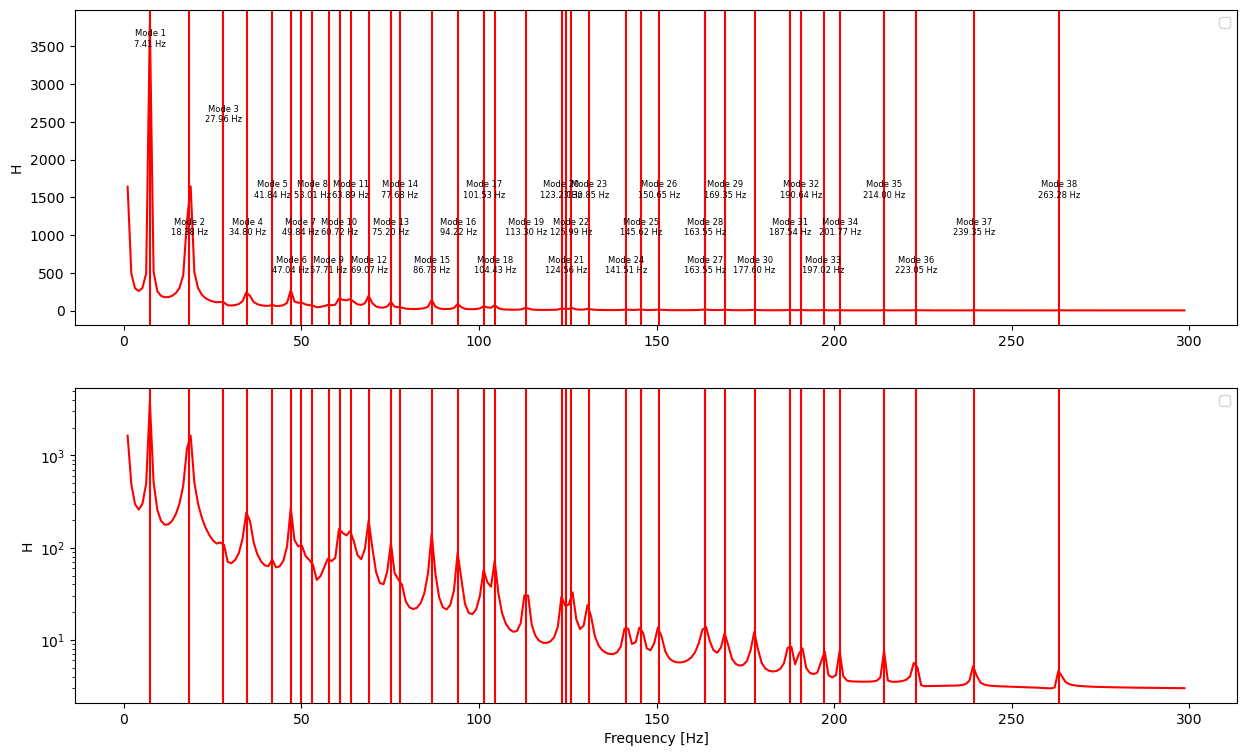

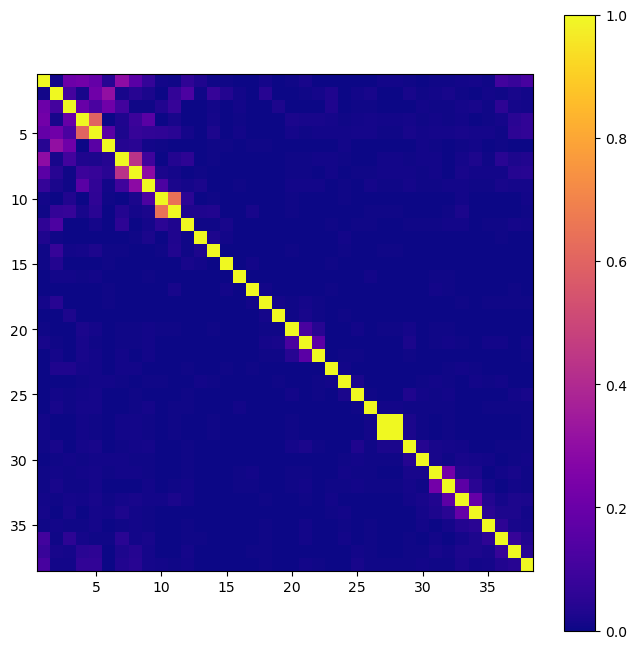

In [19]:
cam.print_modal_data()
fig, ax = plot_FRF(cam)
if test == '1D':
    fig.savefig(os.path.join(EMA_structure.root_simulations, 'FRFs', f'FRF_{EMA_structure.file_name}_1D_roi3x3_3.png'))  #_2D_roi5x5_2
elif test == '2D':
    # fig.savefig(os.path.join(EMA_structure.root_simulations, 'FRFs', f'FRF_{EMA_structure.file_name}_2D_roi7x7_2.png'))
    fig.savefig(os.path.join(EMA_structure.root_simulations, 'FRFs', f'FRF_{EMA_structure.file_name}_2D_roi9x9_2.png'))
fig = plot_MAC(cam, n_modes = len(cam.nat_freq))
if test == '1D':
    fig[0].savefig(os.path.join(EMA_structure.root_simulations, 'MAC', f'MAC_{EMA_structure.file_name}_1D_roi3x3_3.png'))  #_2D_roi5x5_2
elif test == '2D':
    # fig.savefig(os.path.join(EMA_structure.root_simulations, 'MAC', f'MAC_{EMA_structure.file_name}_2D_roi7x7_2.png'))
    fig[0].savefig(os.path.join(EMA_structure.root_simulations, 'MAC', f'MAC_{EMA_structure.file_name}_2D_roi9x9_2.png'))

In [ ]:
# root_mode_shapes = os.path.join(EMA_structure.root_simulations, 'web mode shapes', EMA_structure.file_name + '_1D_roi3x3_2') #_1D_roi3x3

# if not os.path.exists(root_mode_shapes):
#     os.makedirs(root_mode_shapes)

# for mode_number in range(len(cam.nat_freq)): # range(14,n_modes): #  [22]: # 
#     print(f'mode_number: {mode_number}')
#     ani  = animate_mode_shape(cam, mode_number, EMA_structure.tp[EMA_structure.valid_tps]) #, indices_to_plot = indices_to_plot np.delete(tp_lim, biggest_outliers, axis=0)
#     writer = animation.FFMpegWriter(fps=60)
#     ani.save(os.path.join(root_mode_shapes, f'Mode_shape_{EMA_structure.file_name}_{mode_number}.mp4'), writer=writer)
    # plt.close()

C:\Users\thijsmas\AppData\Local\Temp\ipykernel_10168\1926014874.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('seismic')


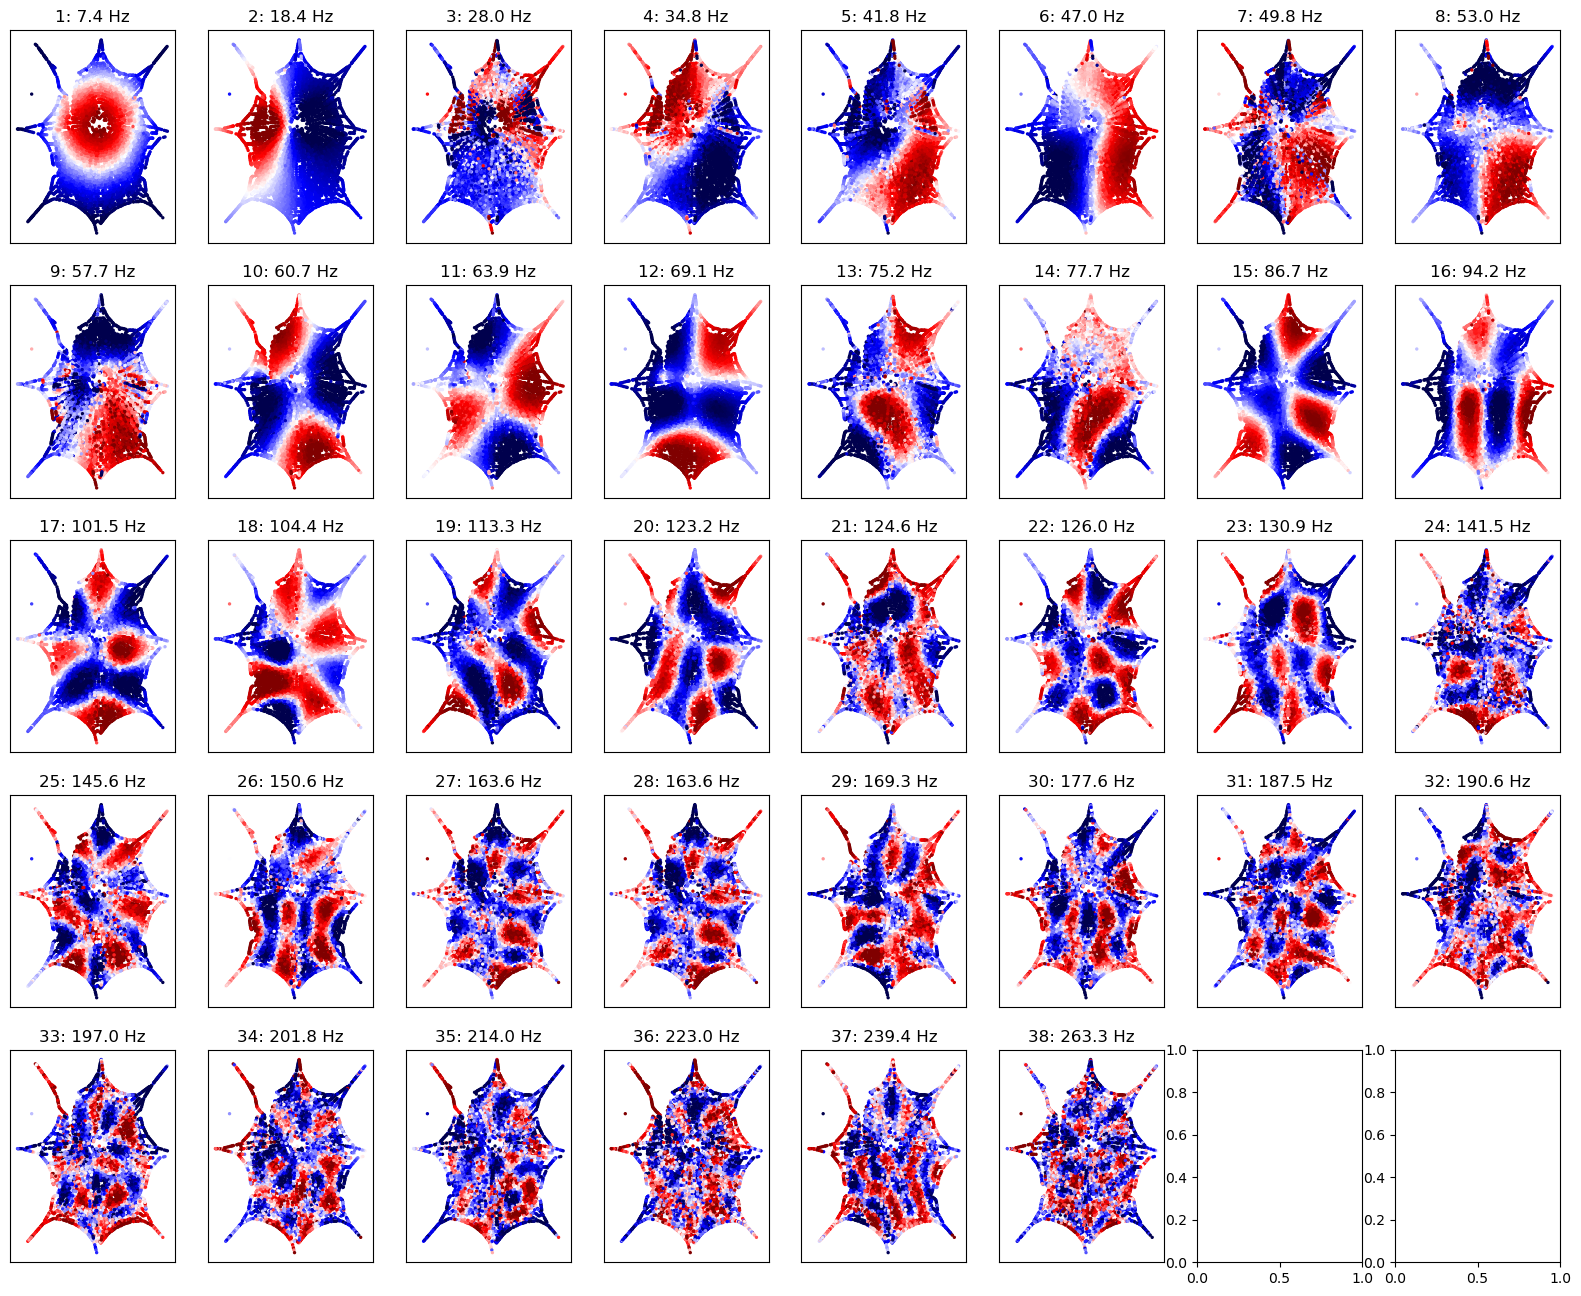

In [20]:
import numpy as np
%matplotlib inline
def plot_flat_mode_shape(cam, mode_number, tp, node, ax):
    A = cam.A
    A_imag = np.imag(A[:, mode_number])# / np.linalg.norm(A[:, mode_number])
    A_real = np.real(A[:, mode_number])# / np.linalg.norm(A[:, mode_number])

    A_abs = np.abs(A[:, mode_number])
    top_95_percentile_value = np.percentile(A_abs, 95)
    top_95_percentile_node = np.argmin(np.abs(A_abs - top_95_percentile_value))

    # node = np.argmax(np.abs(A[:, mode_number]))

    An_i = np.linalg.norm(A[top_95_percentile_node, mode_number])
    An_r = np.linalg.norm(A[top_95_percentile_node, mode_number])
    t_vec = np.linspace(0, 2 * np.pi, 100)
    A_max = 0
    t_max = 0
    for t in t_vec:
        A = An_i * np.sin(t) + An_r * np.cos(t)
        if A < A_max:
            A_max = A
            t_max = t

    Z = A_imag * np.sin(t_max) + A_real * np.cos(t_max)
    top_95_percentile = np.percentile(Z, 95)
    bot_5_percentile = np.percentile(Z, 5)
    v_max = top_95_percentile *1.11
    v_min = bot_5_percentile * 0.89
    if v_min>v_max:
        v_min = np.min(Z)
        v_max = np.max(Z)

    cmap = plt.cm.get_cmap('seismic')
    ax.scatter(tp[:, 1], -tp[:, 0], c=Z, cmap=cmap, s=2, vmax=v_max, vmin=v_min)
    return ax
fn_n = len(cam.nat_freq)
rows, columns  = (5,8)
fig, ax = plt.subplots(rows, columns, figsize=(20, 16))
for mode in range(fn_n): #[12]: #
    mode_i, mode_j = np.unravel_index(mode, (rows, columns))
    ax[mode_i, mode_j] = plot_flat_mode_shape(cam, mode, EMA_structure.tp[EMA_structure.valid_tps], EMA_structure.nearest_nut_index+1, ax[mode_i, mode_j])
    # ax[mode_i, mode_j].set_aspect('equal')
    ax[mode_i, mode_j].set_xticks([])
    ax[mode_i, mode_j].set_yticks([])
    ax[mode_i, mode_j].set_title(f'{mode+1}: {cam.nat_freq[mode]:.1f} Hz')

if test == '1D':
    fig.savefig(os.path.join(EMA_structure.root_simulations, 'web mode shapes flat', f'Mode_shapes_flat_{EMA_structure.file_name}_1D_roi3x3_3.png'), dpi=300, bbox_inches='tight')
elif test == '2D':
    # fig.savefig(os.path.join(EMA_structure.root_simulations, 'web mode shapes flat', f'Mode_shapes_flat_{EMA_structure.file_name}_2D_roi5x5_2.png'), dpi=300, bbox_inches='tight')
    fig.savefig(os.path.join(EMA_structure.root_simulations, 'web mode shapes flat', f'Mode_shapes_flat_{EMA_structure.file_name}_2D_roi7x7_2.png'), dpi=300, bbox_inches='tight')